# Genre and Keyword Analysis

In [196]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import re
from getdata import netflix_df

# Turn off warning messages
import warnings
warnings.filterwarnings("ignore")

In [197]:
# Find the median IMDB votes and median IMDB score of movies above the vote median
med_votes = netflix_df["imdb_votes"].median()
med_score = netflix_df.loc[netflix_df["imdb_votes"] > med_votes]["imdb_score"].median()

# Create DataFrame containing only media above median votes and score
condensed_df = netflix_df.loc[(netflix_df["imdb_votes"] >= med_votes) & (netflix_df["imdb_score"] >= med_score)]
condensed_df.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600
5,ts22164,Monty Python's Flying Circus,SHOW,A British sketch comedy series with the shows ...,1969,TV-14,30,"['comedy', 'european']",['GB'],4.0,tt0063929,8.8,73424.0,17.617,8.306


In [198]:
# Function to turn the "genre" list string into an actual list
def makeList(string):
    # Format the string and return it
    # re.sub() function taken from StackOverflow: https://stackoverflow.com/questions/34860982/replace-the-punctuation-with-whitespace
    clean = re.sub(r"[\[\]\' ]+\ *", "", string)
    clean2 = re.sub(r",", " ", clean)
    if clean2 == "":
        return []
    else:
        return list(clean2.split(" "))

## Single Genre Analysis of Movies and Shows

In [199]:
# Create array for storing unique genres
genre_data = []

# Iterate over all rows
for index, row in condensed_df.iterrows():
    # Turn genre string into list
    genre_list = makeList(row["genres"])

    # Iterate over all genres found in the row
    for genre in genre_list:
        # Check if the genre has already been added to genre_data
        # If so, increment the "total" and either "movie" or "show" depending on the type
        # If not, append it to genre_data with appropriate starting values based on type
        if(row["type"] == "MOVIE"):
            if(not any(g["word"] == genre for g in genre_data)):
                genre_data.append({"word": genre, "total": 1, "movies": 1, "shows": 0})
            else:
                genre_data[next((index for (index, g) in enumerate(genre_data) if g["word"] == genre), None)]["total"] += 1
                genre_data[next((index for (index, g) in enumerate(genre_data) if g["word"] == genre), None)]["movies"] += 1
        else:
            if(not any(g["word"] == genre for g in genre_data)):
                genre_data.append({"word": genre, "total": 1, "movies": 0, "shows": 1})
            else:
                genre_data[next((index for (index, g) in enumerate(genre_data) if g["word"] == genre), None)]["total"] += 1
                genre_data[next((index for (index, g) in enumerate(genre_data) if g["word"] == genre), None)]["shows"] += 1

genre_data

[{'word': 'drama', 'total': 939, 'movies': 467, 'shows': 472},
 {'word': 'crime', 'total': 337, 'movies': 147, 'shows': 190},
 {'word': 'action', 'total': 315, 'movies': 152, 'shows': 163},
 {'word': 'thriller', 'total': 358, 'movies': 161, 'shows': 197},
 {'word': 'european', 'total': 143, 'movies': 92, 'shows': 51},
 {'word': 'fantasy', 'total': 198, 'movies': 76, 'shows': 122},
 {'word': 'comedy', 'total': 547, 'movies': 283, 'shows': 264},
 {'word': 'war', 'total': 79, 'movies': 45, 'shows': 34},
 {'word': 'western', 'total': 14, 'movies': 8, 'shows': 6},
 {'word': 'documentation', 'total': 250, 'movies': 145, 'shows': 105},
 {'word': 'romance', 'total': 245, 'movies': 138, 'shows': 107},
 {'word': 'history', 'total': 136, 'movies': 74, 'shows': 62},
 {'word': 'horror', 'total': 90, 'movies': 33, 'shows': 57},
 {'word': 'scifi', 'total': 195, 'movies': 42, 'shows': 153},
 {'word': 'family', 'total': 115, 'movies': 51, 'shows': 64},
 {'word': 'animation', 'total': 150, 'movies': 50,

### Combined Movies/Shows

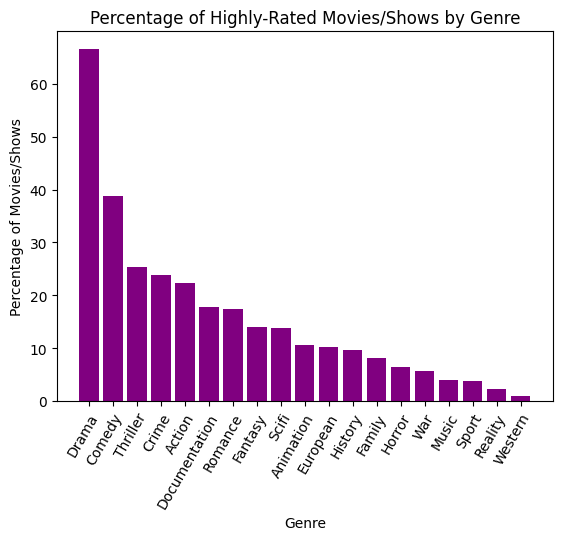

In [200]:
# Sort data by total
# sorted() function taken from StackOverflow: https://stackoverflow.com/questions/72899/how-to-sort-a-list-of-dictionaries-by-a-value-of-the-dictionary-in-python
sorted_total_data = sorted(genre_data, key=lambda x: x["total"], reverse=True)

# Get the total amount of movies, shows, and them combined
total_movies = condensed_df["type"].value_counts()["MOVIE"]
total_shows = condensed_df["type"].value_counts()["SHOW"]
total = total_movies + total_shows

# Set x-ticks
genres = [g["word"].capitalize() for g in sorted_total_data]

# Set x and y axes
x_axis = np.arange(len(genres))
y_axis = [(g["total"] / total) * 100 for g in sorted_total_data]

# Graph the combined genre percentages
plt.bar(x_axis, y_axis, color="purple")
plt.xticks(x_axis, genres, rotation=60, ha="right", rotation_mode="anchor")
plt.title(f"Percentage of Highly-Rated Movies/Shows by Genre")
plt.xlabel("Genre")
plt.ylabel("Percentage of Movies/Shows")
plt.show()

### Movies Only

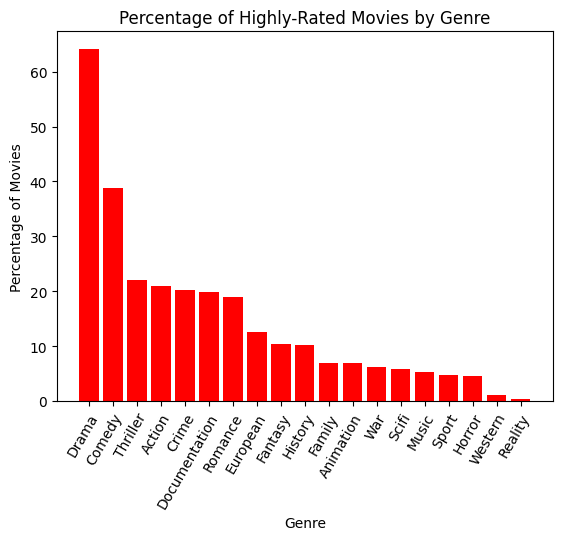

In [201]:
# Sort data by movies
# sorted() function taken from StackOverflow: https://stackoverflow.com/questions/72899/how-to-sort-a-list-of-dictionaries-by-a-value-of-the-dictionary-in-python
sorted_movie_data = sorted(genre_data, key=lambda x: x["movies"], reverse=True)

# Set x-ticks
genres = [g["word"].capitalize() for g in sorted_movie_data]

# Set x and y axes
x_axis = np.arange(len(genres))
y_axis = [(g["movies"] / total_movies) * 100 for g in sorted_movie_data]

# Graph the movie genre percentages
plt.bar(x_axis, y_axis, color="red")
plt.xticks(x_axis, genres, rotation=60, ha="right", rotation_mode="anchor")
plt.title(f"Percentage of Highly-Rated Movies by Genre")
plt.xlabel("Genre")
plt.ylabel("Percentage of Movies")
plt.show()

### Shows Only

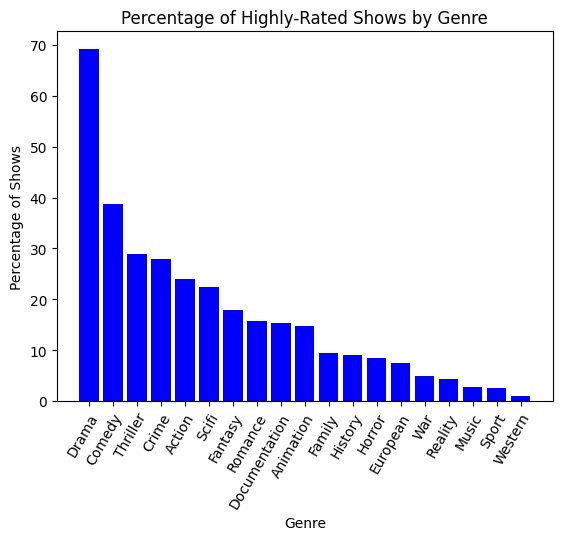

In [202]:
# Sort data by shows
# sorted() function taken from StackOverflow: https://stackoverflow.com/questions/72899/how-to-sort-a-list-of-dictionaries-by-a-value-of-the-dictionary-in-python
sorted_show_data = sorted(genre_data, key=lambda x: x["shows"], reverse=True)

# Set x-ticks
genres = [g["word"].capitalize() for g in sorted_show_data]

# Set x and y axes
x_axis = np.arange(len(genres))
y_axis = [(g["shows"] / total_shows) * 100 for g in sorted_show_data]

# Graph the show genre percentages
plt.bar(x_axis, y_axis, color="blue")
plt.xticks(x_axis, genres, rotation=60, ha="right", rotation_mode="anchor")
plt.title(f"Percentage of Highly-Rated Shows by Genre")
plt.xlabel("Genre")
plt.ylabel("Percentage of Shows")
plt.show()

## Genre-Pair Analysis of Movies and Shows

In [231]:
# Movies and Shows Combined

# Create copy of condensed DataFrame and add new column
genre_group_df = condensed_df.copy()
genre_group_df["Popular Genres"] = ""

# List of genres we're searching for
popular_genres = ["comedy", "crime", "family", "fantasy", "romance", "scifi", "thriller"]

# Iterate over all movies/shows
for index, row in genre_group_df.iterrows():
    # Turn the genres string into a sorted list
    genre_list = makeList(row["genres"])
    genre_list.sort()

    # Variables
    contains_genre = False
    popular_genres_string = ""

    # Iterate over genres we're searching for
    # If it exists, add it to string
    for genre in popular_genres:
        if genre in genre_list:
            popular_genres_string = popular_genres_string + genre + " / "
            contains_genre = True
    
    # Remove " / " at end of string
    popular_genres_string = popular_genres_string[:-3]
    
    # If exactly 2 genres were found in the list, add them to the new column
    # Otherwise, drop the row
    if contains_genre:
        if(popular_genres_string.count("/") == 0 or popular_genres_string.count("/") > 1):
            genre_group_df.drop(index, inplace=True)
        else:
            genre_group_df.at[index, "Popular Genres"] = popular_genres_string
    else:
        genre_group_df.drop(index, inplace=True)

genre_group_df.head()


,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,Popular Genres
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811,comedy / fantasy
7,tm14873,Dirty Harry,MOVIE,When a madman dubbed 'Scorpio' terrorizes San ...,1971,R,102,"['thriller', 'action', 'crime']",['US'],NaN,tt0066999,7.7,155051.0,12.817,7.500,crime / thriller
13,tm16479,White Christmas,MOVIE,Two talented song-and-dance men team up after ...,1954,NaN,115,"['romance', 'comedy']",['US'],NaN,tt0047673,7.5,42488.0,8.915,7.200,comedy / romance
14,tm135083,Cairo Station,MOVIE,"Qinawi, a physically challenged peddler who ma...",1958,NaN,77,"['drama', 'crime', 'comedy']",['EG'],NaN,tt0051390,7.5,4471.0,5.546,7.300,comedy / crime
39,tm138875,When Harry Met Sally...,MOVIE,"During their travel from Chicago to New York, ...",1989,R,96,"['comedy', 'romance', 'drama']",['US'],NaN,tt0098635,7.7,216199.0,15.123,7.400,comedy / romance


### Combined Movies/Shows

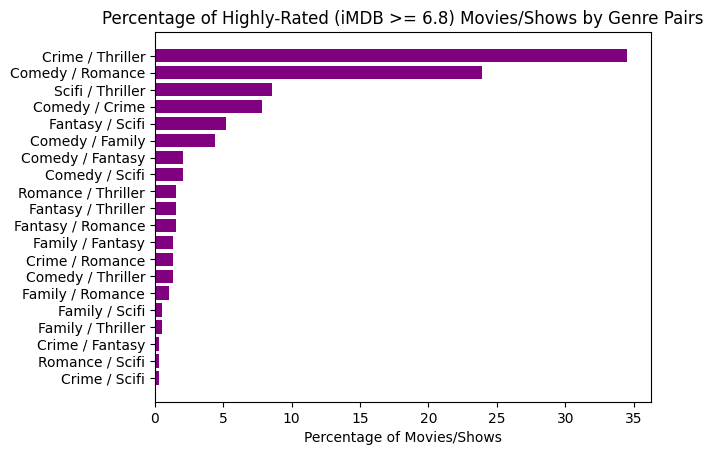

In [227]:
# Set x-axis
sorted_genre_groups = genre_group_df.groupby(["Popular Genres"]).size().sort_values()
genre_sum = sorted_genre_groups.sum()
x_axis = [(g / genre_sum) * 100 for g in sorted_genre_groups]

# Set y-axis
y_axis = np.arange(len(sorted_genre_groups))

# Graph the combined genre pairs percentages
plt.barh(y_axis, x_axis, color="purple")
plt.yticks(y_axis, [x.title() for x in sorted_genre_groups.index])
plt.title(f"Percentage of Highly-Rated (iMDB >= {med_score}) Movies/Shows by Genre Pairs")
plt.xlabel("Percentage of Movies/Shows")
plt.show()

### Movies Only

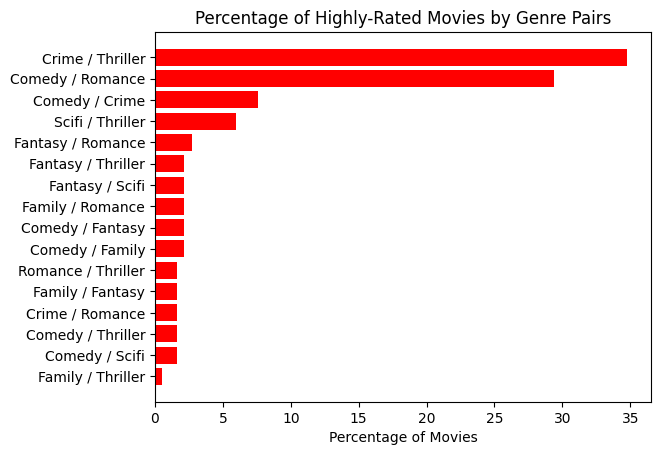

In [233]:
# Set x-axis
sorted_movie_genres = genre_group_df.loc[genre_group_df["type"] == "MOVIE"].groupby(["Popular Genres"]).size().sort_values()
genre_sum = sorted_movie_genres.sum()
x_axis = [(g / genre_sum) * 100 for g in sorted_movie_genres]

# Set y-axis
y_axis = np.arange(len(sorted_movie_genres))

# Graph the combined genre pairs percentages
plt.barh(y_axis, x_axis, color="red")
plt.yticks(y_axis, [x.title() for x in sorted_movie_genres.index])
plt.title(f"Percentage of Highly-Rated Movies by Genre Pairs")
plt.xlabel("Percentage of Movies")
plt.show()

### Shows Only

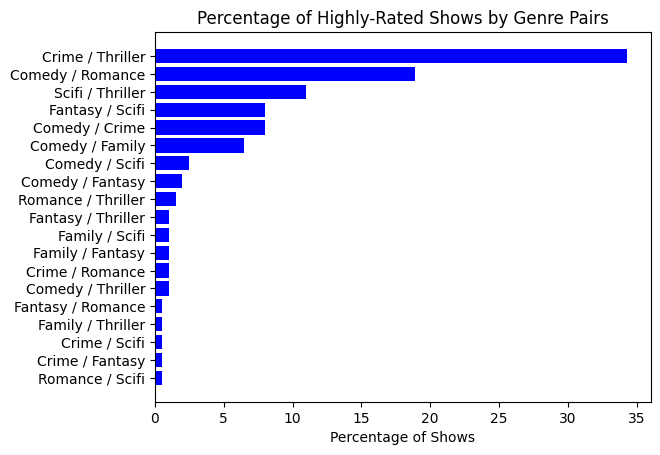

In [234]:
# Set x-axis
sorted_shows_genres = genre_group_df.loc[genre_group_df["type"] == "SHOW"].groupby(["Popular Genres"]).size().sort_values()
genre_sum = sorted_shows_genres.sum()
x_axis = [(g / genre_sum) * 100 for g in sorted_shows_genres]

# Set y-axis
y_axis = np.arange(len(sorted_shows_genres))

# Graph the combined genre pairs percentages
plt.barh(y_axis, x_axis, color="blue")
plt.yticks(y_axis, [x.title() for x in sorted_shows_genres.index])
plt.title(f"Percentage of Highly-Rated Shows by Genre Pairs")
plt.xlabel("Percentage of Shows")
plt.show()

## Keyword Analysis of Genre-Pair Movies

In [218]:
# Create array for storing unique words
words_1 = []
words_2 = []

# Store genres
genre_1 = "crime"
genre_2 = "thriller"
genre_3 = "comedy"
genre_4 = "romance"

genre_count_1 = 0
genre_count_2 = 0


# Iterate over all rows
for index, row in movies_group_df.iterrows():
    if(row["Popular Genres"] == f"{genre_1} / {genre_2}"):
        genre_count_1 += 1
        
        # Turn description into list of words
        desc = row["description"].lower()
        desc_list = re.sub(r"[^\w\s]", "", desc).split(" ")

        # Iterate over all words found in the row
        for word in desc_list:
            # Check if the word has already been added to words array
            # If so, increment the "count"
            # If not, append it
            if(not any(w["word"] == word for w in words_1)):
                words_1.append({"word": word, "count": 1})
            else:
                words_1[next((index for (index, w) in enumerate(words_1) if w["word"] == word), None)]["count"] += 1
    elif(row["Popular Genres"] == f"{genre_3} / {genre_4}"):
        genre_count_2 += 1
        
        # Turn description into list of words
        desc = row["description"].lower()
        desc_list = re.sub(r"[^\w\s]", "", desc).split(" ")

        # Iterate over all words found in the row
        for word in desc_list:
            # Check if the word has already been added to words array
            # If so, increment the "count"
            # If not, append it
            if(not any(w["word"] == word for w in words_2)):
                words_2.append({"word": word, "count": 1})
            else:
                words_2[next((index for (index, w) in enumerate(words_2) if w["word"] == word), None)]["count"] += 1

sorted_words_1 = sorted(words_1, key=lambda x: x["word"])
sorted_words_2 = sorted(words_2, key=lambda x: x["word"])
sorted_words_1

[{'word': '', 'count': 9},
 {'word': '12yearold', 'count': 2},
 {'word': '1934', 'count': 1},
 {'word': '1956', 'count': 1},
 {'word': '1960s', 'count': 1},
 {'word': '1974', 'count': 1},
 {'word': '2011', 'count': 1},
 {'word': '22', 'count': 1},
 {'word': '300000', 'count': 1},
 {'word': '60s', 'count': 1},
 {'word': '77', 'count': 1},
 {'word': 'a', 'count': 126},
 {'word': 'abducted', 'count': 1},
 {'word': 'about', 'count': 1},
 {'word': 'accepted', 'count': 1},
 {'word': 'accepting', 'count': 1},
 {'word': 'accident', 'count': 1},
 {'word': 'accidentally', 'count': 1},
 {'word': 'acclaimed', 'count': 1},
 {'word': 'achieve', 'count': 1},
 {'word': 'action', 'count': 1},
 {'word': 'actually', 'count': 1},
 {'word': 'advantage', 'count': 1},
 {'word': 'affair', 'count': 1},
 {'word': 'afford', 'count': 1},
 {'word': 'after', 'count': 6},
 {'word': 'against', 'count': 2},
 {'word': 'agent', 'count': 4},
 {'word': 'aiding', 'count': 1},
 {'word': 'aires', 'count': 1},
 {'word': 'alar

In [219]:
# Store stop words to filter out
stop_words = ["", "a", "an", "the", "and", "but", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with",
              "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to",
              "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here",
              "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such",
              "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "can", "will", "just", "story", "it", "film",
              "two", "finds", "get", "has", "become", "him", "himself", "three", "be", "been", "is", "his", "who", "that", "are", "he",
              "his", "that", "her", "they", "its", "this", "that", "their", "lives", "must", "meets", "new", "one", "around", "have", "she",
              "save", "small", "wakes", "them", "go", "which", "bring", "life", "man", "find", "comes", "people"]
stop_words.sort()

# Remove all stop words from first word array
for word in sorted_words_1[:]:
    if word["word"] in stop_words:
        sorted_words_1.remove(word)

# Remove all stop words from first word array
for word in sorted_words_2[:]:
    if word["word"] in stop_words:
        sorted_words_2.remove(word)

# Sort the words by count
sorted_words_1 = sorted(sorted_words_1, key=lambda x: x["count"], reverse=True)
sorted_words_2 = sorted(sorted_words_2, key=lambda x: x["count"], reverse=True)
sorted_words_1

[{'word': 'police', 'count': 11},
 {'word': 'crime', 'count': 9},
 {'word': 'young', 'count': 8},
 {'word': 'case', 'count': 6},
 {'word': 'murder', 'count': 6},
 {'word': 'cop', 'count': 5},
 {'word': 'family', 'count': 5},
 {'word': 'frank', 'count': 5},
 {'word': 'killer', 'count': 5},
 {'word': 'son', 'count': 5},
 {'word': 'agent', 'count': 4},
 {'word': 'caught', 'count': 4},
 {'word': 'crimes', 'count': 4},
 {'word': 'detective', 'count': 4},
 {'word': 'officer', 'count': 4},
 {'word': 'past', 'count': 4},
 {'word': 'serial', 'count': 4},
 {'word': 'suspects', 'count': 4},
 {'word': 'veteran', 'count': 4},
 {'word': 'whose', 'count': 4},
 {'word': 'years', 'count': 4},
 {'word': 'becomes', 'count': 3},
 {'word': 'ben', 'count': 3},
 {'word': 'better', 'count': 3},
 {'word': 'boss', 'count': 3},
 {'word': 'criminal', 'count': 3},
 {'word': 'death', 'count': 3},
 {'word': 'desperate', 'count': 3},
 {'word': 'different', 'count': 3},
 {'word': 'doctor', 'count': 3},
 {'word': 'even

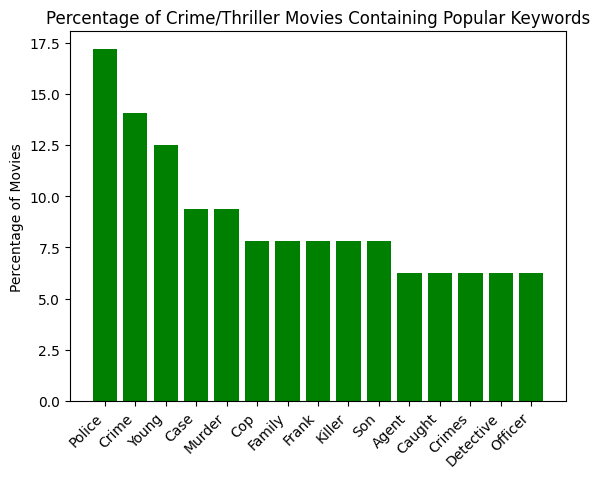

In [224]:
# Set x-ticks
num_bars = 15
top_words_1 = sorted_words_1[:num_bars]
words_1 = [w["word"].capitalize() for w in top_words_1]

# Set x and y axes
x_axis = np.arange(len(top_words_1))
y_axis = [(w["count"] / genre_count_1) * 100 for w in top_words_1]

# Graph the show genre percentages
plt.bar(x_axis, y_axis, color="green")
plt.xticks(x_axis, words_1, rotation=45, ha="right")
plt.title(f"Percentage of {genre_1.capitalize()}/{genre_2.capitalize()} Movies Containing Popular Keywords")
plt.ylabel("Percentage of Movies")
plt.show()

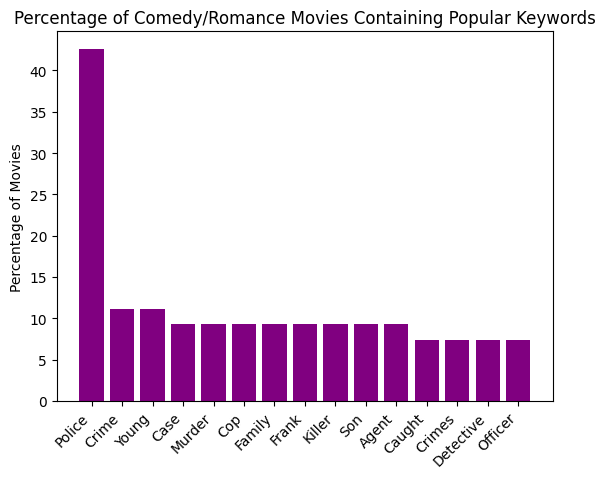

In [225]:
# Set x-ticks
num_bars = 15
top_words_2 = sorted_words_2[:num_bars]
words_2 = [w["word"].capitalize() for w in top_words_2]

# Set x and y axes
x_axis = np.arange(len(top_words_2))
y_axis = [(w["count"] / genre_count_2) * 100 for w in top_words_2]

# Graph the show genre percentages
plt.bar(x_axis, y_axis, color="purple")
plt.xticks(x_axis, words_1, rotation=45, ha="right")
plt.title(f"Percentage of {genre_3.capitalize()}/{genre_4.capitalize()} Movies Containing Popular Keywords")
plt.ylabel("Percentage of Movies")
plt.show()